Williamson-Hall Analysis Notebook - For Sharing
Connor J. Dolan
July 20, 2023

# Setup

In [2]:
# Import Necessary Packages
from scipy import *
from matplotlib import pylab as plt
from scipy.optimize import fmin
from scipy.optimize import curve_fit
import seaborn as sns
import numpy as np
from apstools import xrf
import frgtools.misc as frgm # import frgtools at https://github.com/fenning-research-group/Python-Utilities
from natsort import natsorted
import h5py as h5
from apstools import s26 # import apstools at https://github.com/fenning-research-group/APS
import pandas as pd
import math

In [9]:
def pseudo_voigt(x, amplitude, center, sigma, eta): # Defines pseudo-voigt fitting function we'll be using (linear combination of gaussian, lorentzian fits)
        sigma_g = sigma / np.sqrt(2 * np.log(2))  # Convert FWHM to standard deviation
        return amplitude * ((1 - eta) * np.exp(-((x - center)**2) / (2 * sigma_g**2)) + eta / (1 + ((x - center) / sigma_g)**2))

def double_pseudo_voigt(x, amplitude1, center1, sigma1, eta1, amplitude2, sigma2, eta2):
        fixed_distance = 0.1
        center2 = center1 + 0.1
        sigma_g1 = sigma1 / np.sqrt(2 * np.log(2))  # Convert FWHM to standard deviation
        sigma_g2 = sigma2 / np.sqrt(2 * np.log(2))
        return (amplitude1 * ((1 - eta1) * np.exp(-((x - center1)**2) / (2 * sigma_g1**2)) + eta1 / (1 + ((x - center1) / sigma_g1)**2)) +
                amplitude2 * ((1 - eta2) * np.exp(-((x - center2)**2) / (2 * sigma_g2**2)) + eta2 / (1 + ((x - center2) / sigma_g2)**2)))


In [4]:
### CJD note: here is where you load in your data and convert to a list or array of two theta (tt) and counts (counts)

# Define working directory
basedir = '/Users/connordolan/Library/CloudStorage/GoogleDrive-cdolan@ucsd.edu/Shared drives/XTAL/Experiments/20230926_Films/XRD/Data'
# Load and sort files, store in "fids" list
fids = frgm.listdir(basedir, 'hdf5')
fids = natsorted(fids)
raw = h5.File(fids[1])
me = h5.File(fids[0])
sonic = h5.File(fids[2])

# Calculate W-H Parameters

In [44]:
def WH(tt, counts, energy = 8.04, angle_guesses = [14.3, 20.1, 24.6, 28.45, 31.8, 34.9, 40.5, 43], angle_offset = 0, color = 'red', threshold = 0.75, shareaxis = True, plot_fits = False, double_peak = True):
    """
    Processes XRD pattern into a Williamson-Hall plot for determination of strain and crystallite size.
    Inputs: 
    tt - array or array-like, two-theta angles for XRD pattern
    counts: array or array-like, XRD counts at each point in XRD pattern
    energy: X-Ray energy (keV). default: 8.04 (Cu-K)
    angle_guesses: guesses at where peaks will show up (tabulated for Cu-K FAPbI3. The code will adjust these if you put in a different energy, but the option to change them is there if you want to omit some)
    angle_offset: a uniform offset to be applied to angle_guesses in case we have a perovskite with different lattice parameter - if you use "plot_fits = True", then check to make sure peaks are within the bounds being plotted. If not, change this parameter until they are!
    shareaxis: a parameter to be called in the multipleWH function - doesn't do anything except create new figure here so leave as False if only plotting one
    plot_fits: Plots fits with r-squared value as title so we can visually inspect to make sure fitting is working.
    double_peak: Bool, whether we have k alpha 1 and k alpha 2 contributions
    """
    from scipy.signal import savgol_filter

    data = []
    fit_colors = plt.cm.copper(np.linspace(0,0,len(angle_guesses)))

    # counts = savgol_filter(counts,11,2)
    # this code offsets the angles in angle_guesses by angle_offset
    angle_guesses_ = angle_guesses.copy()
    angle_guesses = []
    for angle in angle_guesses_:
        angle_guesses.append(angle - angle_offset)

    # creates subplots for plotting fits if we have this option selected 
    if plot_fits:
        fig, ax = plt.subplots(8,1, figsize = (4,10), dpi = 400, facecolor = 'white')
        shareaxis = False
        ax.flatten()
        
    centers = []
    widths = []
    if energy != 8.04:
        angle_guesses = s26.twotheta_adjust(np.array(angle_guesses), energy) # corrects for different energy (values are tabulated for Cu-K)

    i = 0
    for angle in angle_guesses:
        d = 1.54056/(2*np.sin((angle/2)*math.pi/180))
        delta = (np.arcsin(1.54439/(2*d))-np.arcsin(1.54046/(2*d)))*360/math.pi

        def double_pseudo_voigt(x, amplitude1, center1, sigma1, eta1, amplitude2, sigma2, eta2):
            fixed_distance = delta # in this version of the code, the center position of the ka2 peak is fixed based on the calculated difference in diffracting angles (delta) from the ka1 and ka2 light sources
            center2 = center1 + delta
            sigma_g1 = sigma1 / np.sqrt(2 * np.log(2))  # Convert FWHM to standard deviation
            sigma_g2 = sigma2 / np.sqrt(2 * np.log(2))
            return (amplitude1 * ((1 - eta1) * np.exp(-((x - center1)**2) / (2 * sigma_g1**2)) + eta1 / (1 + ((x - center1) / sigma_g1)**2)) +
                    amplitude2 * ((1 - eta2) * np.exp(-((x - center2)**2) / (2 * sigma_g2**2)) + eta2 / (1 + ((x - center2) / sigma_g2)**2)))

        low_index = np.abs(tt - (angle-0.35)).argmin() # low angle for fitting bounds
        high_index = np.abs(tt - (angle+0.35)).argmin() # high angle for fitting bounds

        # Fit Gaussian to the data
        x_temp = tt[low_index:high_index] # temporary two theta values for the region of interest around our peak
        y_temp = counts[low_index:high_index] # temporary counts for the region of interest around our peak
        y_temp = y_temp-y_temp.min() # Not sure if this is proper, but fits look much better when i do this as it doesn't try to fit background and we don't have overlapping peaks here (ideally)
        y_peak = np.max(y_temp)
        x_max = x_temp[np.argmax(y_temp)]

        ### Finding K alpha 1 and 2 peak splitting
        def deltatheta(theta):
            d = 1.54056/(2*np.sin((theta/2)*math.pi/180))
            return((np.arcsin(1.54439/(2*d))-np.arcsin(1.54046/(2*d)))*360/math.pi)

        delta = deltatheta(angle)

        if double_peak == False:
            # SINGLE PSEUDO VOIGT
            # Height, center, width, eta
            p0 = [y_peak, x_max, 0.03 + 0.0025 * i, 0.75]  # Initial guess for the parameters 

            bounds = ([0.95*y_peak, # First peak min height
            0,                      # First peak min center
            0.03 + 0.0025*i,        # First peak min stdev
            0],                      # First peak min Lorentzian contribution

            [1.5*y_peak,            # First peak max height
            np.inf,                 # First peak max center
            0.2,                    # First peak max stdev
            1])                     # First peak max Lorentzian Contribution

            popt, pcov = curve_fit(pseudo_voigt, x_temp, y_temp, p0=p0, bounds = bounds, maxfev = 500000) #  now we fit! (popt is [amplitude, center, fwhm, ratio of gaussian:lorentzian used in fit] in order of indexing)

            r_squared = 1 - np.sum((y_temp - pseudo_voigt(x_temp, *popt))**2) / np.sum((y_temp - np.mean(y_temp))**2)

        else:
            # DOUBLE PSEUDO VOIGT
            # Height, center, width, eta
            # print(delta)
            p0 = [y_peak, x_max, 0.03 + 0.0025 * i, 0.75, y_peak/2, 0.03 + 0.0025 * i, 0.75]  # Initial guess for the parameters 

            bounds = ([0.95*y_peak, # First peak min height
            x_max-0.01-delta/3,                      # First peak min center
            0.025 + 0.002 * i,        # First peak min stdev
            0,                      # First peak min Lorentzian contribution
            0.45*y_peak,            # Second peak min height
            0.025 + 0.002 * i,         # Second peak min stdev
            0],                     # Second peak min Lorentzian contribution

            [1.2*y_peak,            # First peak max height
            x_max+delta/2,             # First peak max center
            0.06 + 0.005 * i,       # First peak max stdev
            1,                      # First peak max Lorentzian Contribution
            0.55*y_peak,             # Second peak max height
            0.06 + 0.005 * i,      # Second peak max stdev
            1])                     # Second peak max Lorentzian Contribution

            popt, pcov = curve_fit(double_pseudo_voigt, x_temp, y_temp, p0=p0, bounds = bounds, maxfev = 500000) #  now we fit! (popt is [amplitude, center, fwhm, ratio of gaussian:lorentzian used in fit] in order of indexing)
            r_squared = 1 - np.sum((y_temp - double_pseudo_voigt(x_temp, *popt))**2) / np.sum((y_temp - np.mean(y_temp))**2)

        data.append([popt[1], popt[5]-popt[1]])

        if r_squared > threshold and y_peak > 10: # Optional check on the error of the fit - doesn't include fits that are bad
            # print(popt[2])
            centers.append(popt[1]) # param 1 is the center position of the fit
            widths.append(popt[2]) # param 2 is the fwhm of the fit
            if i == 0:
                print(popt[0])
        if plot_fits:
        # Plot the original data and fitted Gaussian
            ax[i].plot(x_temp-0.3, y_temp, 'ko', markersize = 1, label='Raw Data')
            if double_peak == False:
                ax[i].plot(x_temp, pseudo_voigt(x_temp, *popt), 'r--')
            else:
                ax[i].plot(x_temp-0.3, double_pseudo_voigt(x_temp, *popt), 'r-', linewidth = 0.5, label = 'Combined Fits')
                ax[i].plot(x_temp-0.3, pseudo_voigt(x_temp, *popt[0:4]), 'r--', linewidth = 0.5, label = 'Ka1 Fit')
                ax[i].plot(x_temp-0.3, pseudo_voigt(x_temp, popt[4], popt[1]+delta, popt[5], popt[6]), 'b--', linewidth = 0.5, label = 'Ka2 Fit')
                ax[i].axvline(popt[1]-0.3, color = 'k', linewidth = 0.5)
                ax[i].axvline(popt[1]+delta-0.3, color = 'k', linewidth = 0.5)
            ax[i].set_title('R-Squared: ' + "%.4f"%r_squared)

            # ax[i].axvline(bounds[0][1], color = 'r', linestyle = '--', linewidth = 0.25)
            # ax[i].axvline(bounds[1][1], color = 'r', linestyle = '--', linewidth = 0.25)

            # ax[i].axvline(bounds[0][5], color = 'k', linestyle = '--', linewidth = 0.25)
            # ax[i].axvline(bounds[1][5], color = 'k', linestyle = '--', linewidth = 0.25)
            # ax[i].text(x_temp.mean()+0.4, y_peak*.75, '%.4f'%((popt[5]-popt[1])-delta))
            ax[i].legend(frameon = False, fontsize = 3)
            
            # ax[i].text(x_temp.mean()-0.4, y_peak*.75, '%.3f'%popt[2])
            # ax[i].text(x_temp.mean()+0.4, y_peak*.75, '%.3f'%bounds[1][2])
            plt.tight_layout()
        i+=1
        
    # print(widths)
    c = 3e17 # speed of light, nm per second
    h = 4.136e-15 # Planck's constant, eV * s
    wl = h * c / (energy * 1e3) # wavelength (nm)

    theta  =  np.deg2rad(np.array(centers)/2) # Converts angles to radians

    x = np.sin(theta) # Creates x values of sin(theta)
    y_ = np.deg2rad(widths) # Converts widths to radians
    y = y_*np.cos(theta) # Creates y value array based on angles

    slope,intercept = np.polyfit(x,y,1) # fits a line to the data, we will use the slope + intercept to calculate size and strain
    k = 0.94 # k is a shape-dependent constant between 0.9-1 (assumed 0.94 here)
    
    L = k*wl/intercept # Calculate crystallite size (angstrom/(angstrom/s))

    if shareaxis == False:
        plt.figure(figsize = (4,3), dpi = 200, facecolor='white')

    ax2 = sns.regplot(x, y, ci = 95, color = color) # fitted line plot with bounds
        
    m,c = np.polyfit(x,y,1) # redo the fit to pull the parameters out for quantitative determination of size and strain.

    slope,intercept = np.polyfit(x,y,1) # fits a line to the data, we will use the slope + intercept to calculate size and strain
    k = 0.94 # k is a shape-dependent constant between 0.9-1 (assumed 0.94 here)
    
    L = k*wl/intercept # Calculate crystallite size (angstrom/(angstrom/s))

    # Calculate the residuals
    residuals = y - (slope * x + intercept)

    # Calculate the standard deviation of residuals
    residuals_std = np.std(residuals, ddof=1)  # ddof=1 for sample standard deviation

    # Calculate the standard deviation of the slope and intercept
    n = len(x)
    slope_std = residuals_std / (np.sqrt(np.sum((x - np.mean(x)) ** 2)) * np.sqrt(n - 1))
    intercept_std = k*wl/residuals_std * np.sqrt(np.sum(x ** 2) / (n * np.sum((x - np.mean(x)) ** 2)))

    # plt.plot(np.linspace(min(x), max(x), 100), m*np.linspace(min(x), max(x), 100)+c)

    print('Crystallite Size = ',"%.2f"%L,' +/- ',"%.2f"%intercept_std + ' nm')
    print('Lattice Strain = ',"%.4f"%slope,' +/- ',"%.4f"%slope_std)

    plt.xlabel(r'sin ($\theta$)', fontsize = 14)
    plt.ylabel(r'$\beta$ cos($\theta$)', fontsize = 14)

    return(np.array(data))
    # plt.show()

3053.6804600861756
Crystallite Size =  290.31  +/-  1140.63 nm
Lattice Strain =  0.0023  +/-  0.0003


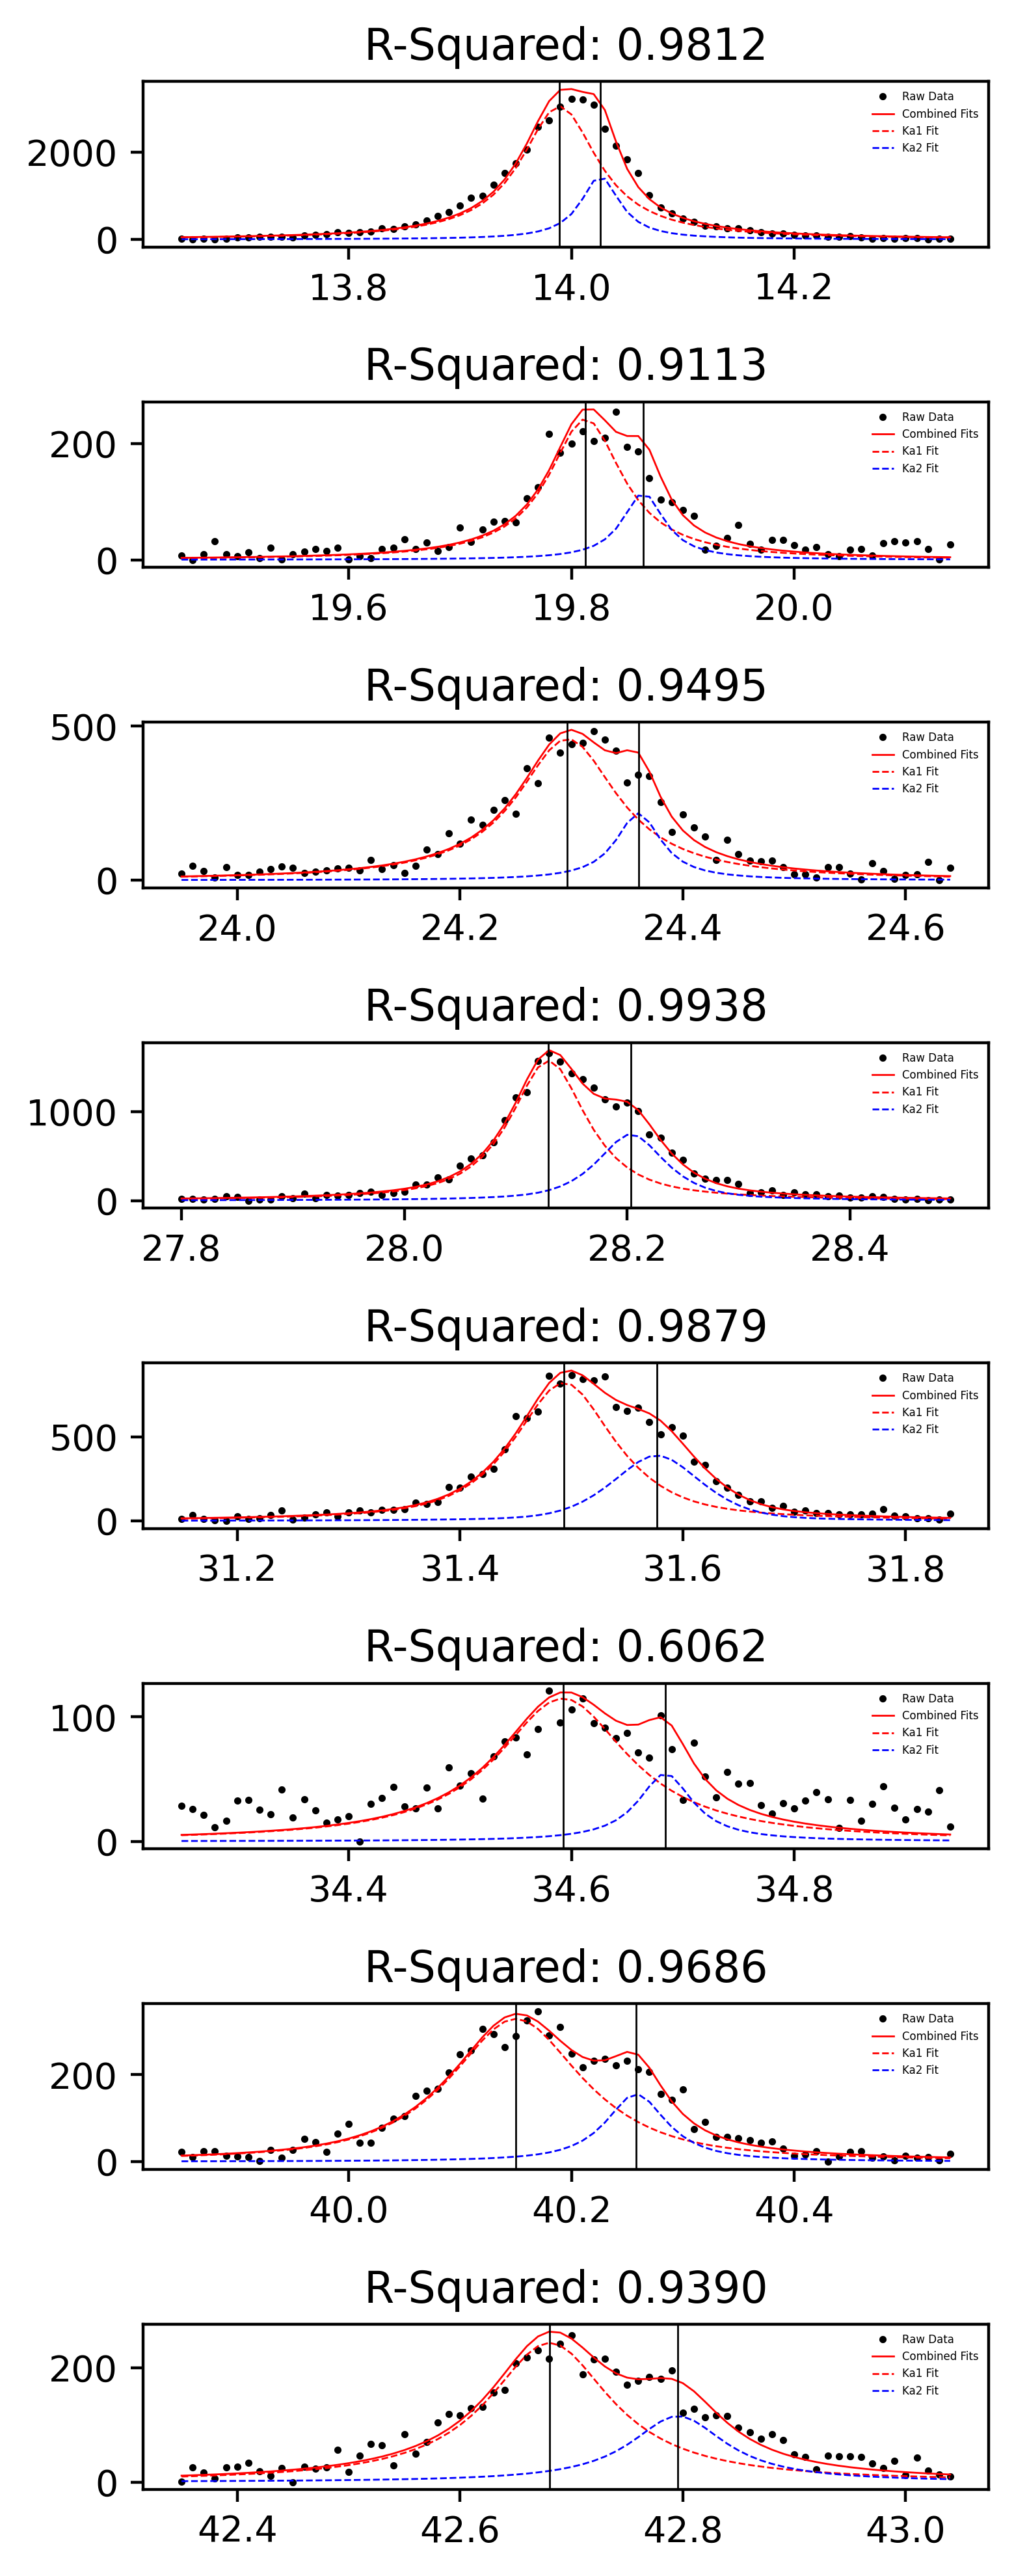

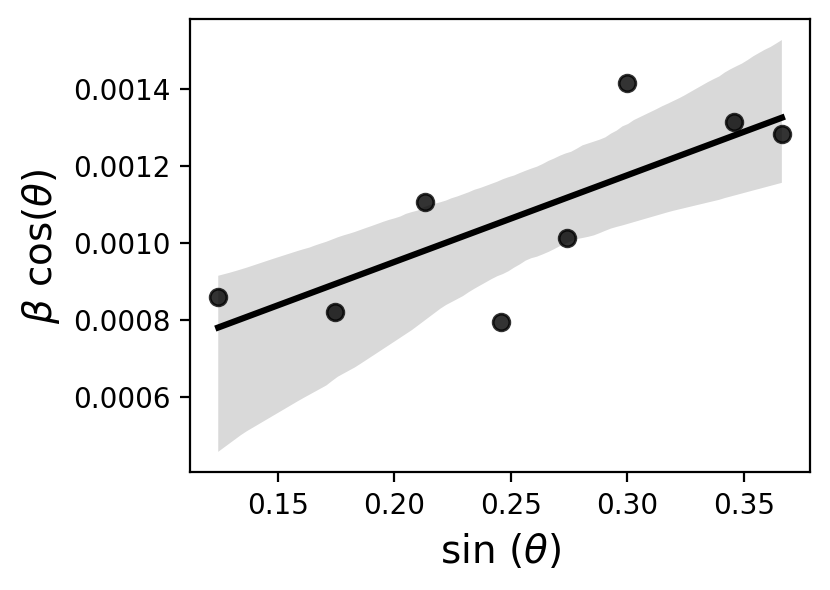

In [45]:
# Plot!
data = WH(tt = raw['entry']['data']['two_theta'][:], 
counts = raw['entry']['data']['data'][0,:,0], 
angle_offset = 0, 
color = 'black', 
threshold = 0.6,
plot_fits = True,
double_peak = True)

In [46]:
# Plots multiple Williamson-Hall Plots on the same or different axes
def multipleWH(tts, counts, keys, color_list, energy = 8.04, angle_guesses = [13.95, 19.8, 24.3, 28.1, 31.5, 34.6, 40.3, 42.7], angle_offset = 0, threshold = 0.75, shareaxis = True, plot_fits = False, double_peak = True):
    """
    tts: array or list of two theta arrays for each scan
    counts: array or list of diffraction counts arrays for each scan
    keys: what each WH plot should be labeled (in order)
    energy: tuple, X-ray energy (don't change if Cu-K)
    angle_guesses: array or list of expected diffraction angles
    angle_offset:  float, offset of peaks from angle guesses
    shareaxis: bool, whether we want each WH plot on a different plot or all on the same
    plot_fits: bool, whether we want to plot the fits for each WH plot (there will be many if this is true (8 x number of scans))
    double_peak: bool, whether we have k alpha 1 and 2 splitting
    """
    
    i=0
    if shareaxis:
            plt.figure(figsize = (4,3), dpi = 200, facecolor = 'white')
    for tt, count, color in zip(tts, counts, color_list):
        print(keys[i])
        i += 1
        WH(tt = tt, counts = count, color = color, energy = energy, angle_guesses=angle_guesses, angle_offset = angle_offset, threshold = threshold, shareaxis = shareaxis, plot_fits = plot_fits, double_peak = double_peak)

Raw
3083.9565268882093
Crystallite Size =  278.39  +/-  1142.86 nm
Lattice Strain =  0.0022  +/-  0.0003
2ME
4518.976577568944
Crystallite Size =  672.00  +/-  970.84 nm
Lattice Strain =  0.0030  +/-  0.0003
SONIC
3530.2341353378138
Crystallite Size =  463.33  +/-  1000.23 nm
Lattice Strain =  0.0024  +/-  0.0003


(0.0, 0.0015986182156273922)

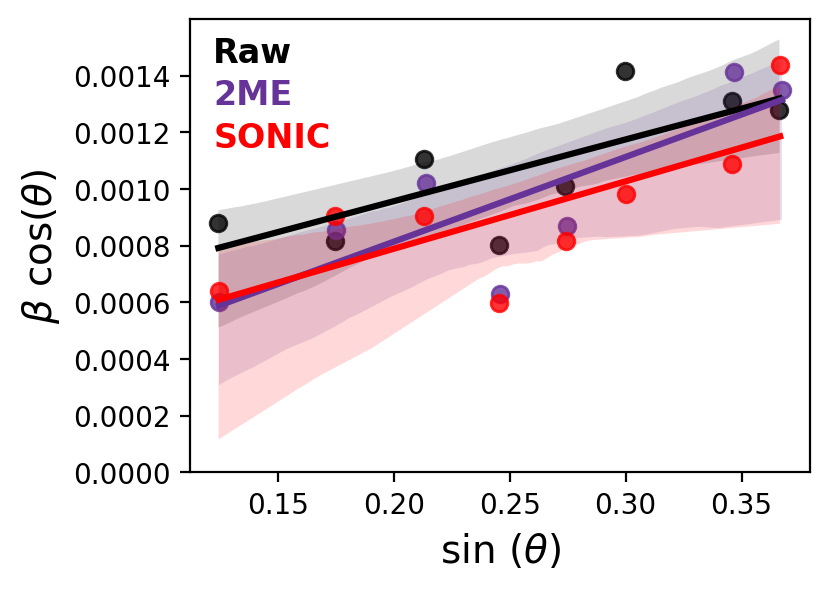

In [48]:
# example for how I might plot three scans on the same axis - input your own tt_1, counts_1, etc.

# colors = plt.cm.copper(np.linspace(0,1,3))
colors = ['black', 'rebeccapurple', 'red']

multipleWH(tts = np.array([raw['entry']['data']['two_theta'][:], me['entry']['data']['two_theta'][:], sonic['entry']['data']['two_theta'][:]]),
 counts = np.array([raw['entry']['data']['data'][0,:,0], me['entry']['data']['data'][0,:,0], sonic['entry']['data']['data'][0,:,0]]),
 keys = ['Raw', '2ME', 'SONIC'],
 color_list=colors,
 threshold = 0.6, 
 angle_guesses = [13.95, 20, 24.45, 28.15, 31.6, 34.8, 40.4, 42.9],
#  angle_guesses = [14.1, 20, 24.4, 42.8],
 angle_offset = -0.15,
 shareaxis = True,
 plot_fits = False,
 double_peak = True)

# plt.ylim(0.0005,0.002)
y_min, y_max = plt.ylim()
x_min, x_max = plt.xlim()


plt.text(x_min + 0.01, y_max - 0.00015, 'Raw', color = colors[0], fontsize = 12, weight = 'bold')
plt.text(x_min + 0.01, y_max - 0.0003, '2ME', color = colors[1], fontsize = 12, weight = 'bold')
plt.text(x_min + 0.01, y_max - 0.00045, 'SONIC', color = colors[2], fontsize = 12, weight = 'bold')

plt.ylim(0)
# plt.title('Williamson-Hall', weight = 'bold')
# plt.savefig('/Users/connordolan/Library/CloudStorage/GoogleDrive-cdolan@ucsd.edu/Shared drives/XTAL/Experiments/20230926_Films/XRD/Plots/WH_all', dpi = 720, bbox_inches = 'tight')